### Example: `mod_5_4`

This notebook shows an example of using the tools in this repo end-to-end to optimize the `mod_5_4.qasm` circuit. In particular, we will reproduce all the steps detailed in Figure 3 of the paper `Quantum Circuit Optimization with AlphaTensor' ([arXiv:2402.14396](https://arxiv.org/abs/2402.14396)).

You'll need a recent Rust compiler, as well as a copy of [`feynver`](https://github.com/meamy/feynman) in your path, and `matplotlib`, `numpy`, and `qiskit` installed in the Python kernel.

First, we can make sure the code is compiled:

In [1]:
%%bash
cd ..
cargo build --release

    Finished `release` profile [optimized] target(s) in 0.09s
note: to see what the problems were, use the option `--future-incompat-report`, or run `cargo report future-incompatibilities --id 3`


Then we can use the `compile` tool to compile `mod_5_4.qasm` to a tensor, putting all the generated files into the `output/` folder. We will enable the `--verify` flag to check that the compiled circuit is equal to the original:

In [ ]:
%%bash
../target/release/circuit-to-tensor compile --verify --emit=block-qasm,circuit-qasm,verify,matrix,tensor outputs/ mod_5_4.qasm

In [54]:
%%bash
echo "[ 1/1]     Parsing successful                                                 "
echo "[ 1/1]   Processing: mod_5_4.qasm                                                   "
echo "[ 1/1]     Hadamard optimization done: initial hcount = 12, final hcount = 0        "
echo "[ 1/1]       Wrote optimized circuit to: outputs/mod_5_4.hopt.qasm                  "
echo "[ 1/1]       Verifying done                                                         "
echo "[ 1/1]         Wrote verification proof to: outputs/mod_5_4.hopt.verify.txt         "
echo "[ 1/1]     Gadgetizing done: 1 blocks => 1 blocks                                   "
echo "[ 1/1]       Verifying done                                                         "
echo "[ 1/1]         Wrote verification proof to: outputs/mod_5_4.partition.verify.txt    "
echo "[ 1/1]       Verifying done                                                         "
echo "[ 1/1]         Wrote verification proof to: outputs/mod_5_4.resynth.verify.txt      "
echo "[ 1/1]       Wrote block circuit to: outputs/mod_5_4.block0.cliffords.qasm          "
echo "[ 1/1]       Wrote block circuit to: outputs/mod_5_4.block1.cnotphase.qasm          "
echo "[ 1/1]       Wrote block circuit to: outputs/mod_5_4.block2.cliffords.qasm          "
echo "[ 1/1]       Wrote block mapping to: outputs/mod_5_4.block1.mapping.txt             "
echo "[ 1/1]       Wrote block matrix to: outputs/mod_5_4.block1.matrix.npy               "
echo "[ 1/1]       Wrote block tensor to: outputs/mod_5_4.block1.tensor.npy               "
# This is here because the jupyter %%bash command doesn't properly capture the output of the compiler

[ 1/1]     Parsing successful                                                 
[ 1/1]   Processing: mod_5_4.qasm                                                   
[ 1/1]     Hadamard optimization done: initial hcount = 12, final hcount = 0        
[ 1/1]       Wrote optimized circuit to: outputs/mod_5_4.hopt.qasm                  
[ 1/1]       Verifying done                                                         
[ 1/1]         Wrote verification proof to: outputs/mod_5_4.hopt.verify.txt         
[ 1/1]     Gadgetizing done: 1 blocks => 1 blocks                                   
[ 1/1]       Verifying done                                                         
[ 1/1]         Wrote verification proof to: outputs/mod_5_4.partition.verify.txt    
[ 1/1]       Verifying done                                                         
[ 1/1]         Wrote verification proof to: outputs/mod_5_4.resynth.verify.txt      
[ 1/1]       Wrote block circuit to: outputs/mod_5_4.block0.cliffords.q

We can see that `feynver` considers the compiled circuit equal to the original:

In [33]:
%%bash
cat outputs/mod_5_4.resynth.verify.txt

Equal (took 0.005s)


The circuit has been compiled down to one tensor, `outputs/mod_5_4.block1.tensor.npy` and a unoptimized decomposition `outputs/mod_5_4.block1.matrix.npy`. Let's inspect these:

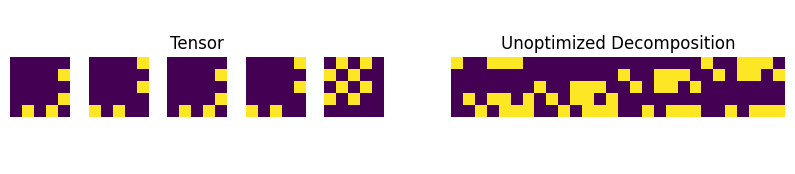

In [34]:
import numpy as np
import matplotlib.pyplot as plt

tensor = np.load("outputs/mod_5_4.block1.tensor.npy")
unoptimized_decomp = np.load("outputs/mod_5_4.block1.matrix.npy")

fig, axes = plt.subplots(1, 7, figsize=(10, 2), width_ratios=[1, 1, 1, 1, 1, 0.5, 28/5])
for i in range(5):
    axes[i].imshow(tensor[i, :])
    axes[i].set_axis_off()
axes[5].set_axis_off()
axes[6].set_axis_off()
axes[6].imshow(unoptimized_decomp)
axes[2].set_title("Tensor")
axes[6].set_title("Unoptimized Decomposition");

The tensor here matches (2b) of Figure 3, and indeed we can see that the unoptimized decomposition _is_ a decomposition of the target tensor:

In [31]:
np.allclose(
    np.einsum('il,jl,kl->ijk', 
        unoptimized_decomp.astype(int), 
        unoptimized_decomp.astype(int),
        unoptimized_decomp.astype(int)
    ) % 2,
    tensor
)

True

This decomposition is highly suboptimal. A simple thing we can do to improve it is remove any duplicate columns mod 2 (this would have been done automatically if we specified the `--zx-preopt` flag to `compile`):

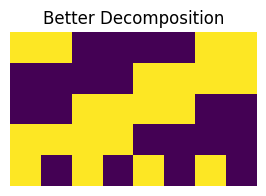

In [200]:
columns, counts = np.unique(unoptimized_decomp, return_counts=True, axis=1)
better_decomp = columns[:, counts % 2 == 1]
better_decomp= better_decomp[:, [5, 4, 1, 0, 3, 2, 7, 6]]

plt.figure(figsize=(5, 2))
plt.imshow(better_decomp)
plt.axis('off')
plt.title('Better Decomposition');

This matches (2a) in Figure 3, and is still a valid decomposition:

In [50]:
np.allclose(
    np.einsum('il,jl,kl->ijk', 
        better_decomp.astype(int), 
        better_decomp.astype(int),
        better_decomp.astype(int)
    ) % 2,
    tensor
)

True

But from (2c) in Figure 3, we know there is an even better decomposition of this tensor. It has rank 7 rather than the rank 8 given by the previous decomposition:

In [53]:
best_decomp = np.array([
    [1, 0, 0, 1, 1, 1, 0],
    [0, 1, 0, 1, 0, 1, 1],
    [1, 0, 0, 1, 1, 1, 0],
    [0, 1, 0, 1, 0, 1, 1],
    [0, 0, 1, 0, 1, 1, 1]
]).astype(bool)

np.save("outputs/mod_5_4.block1.matrix.opt.npy", best_decomp.astype(bool))

np.allclose(
    np.einsum('il,jl,kl->ijk', 
        best_decomp.astype(int), 
        best_decomp.astype(int),
        best_decomp.astype(int)
    ) % 2,
    tensor
)

True

Now we can use the `resynth` tool to generate an equivalent `mod_5_4.block1.cnotphase.qasm` circuit from this new decomposition that is equivalent to the original but has a lower T-count:

In [ ]:
%%bash
../target/release/circuit-to-tensor resynth --gadgets --original=outputs/mod_5_4.block1.matrix.npy --mapping=outputs/mod_5_4.block1.mapping.txt outputs/ outputs/mod_5_4.block1.matrix.opt.npy

In [70]:
%%bash
echo "[ 1/1]     Loading circuit...                                                    "                                                                                               
echo "[ 1/1]     Circuit synthesis complete - CCZ = 1, CS = 0, T = 0                   "                                                                                               
echo "[ 1/1]     Clifford correction factor applied, 9 gates                           "                                                                                              
echo "[ 1/1]       Wrote synthesized circuit to: outputs/mod_5_4.block1.matrix.opt.qasm"

[ 1/1]     Loading circuit...                                                    
[ 1/1]     Circuit synthesis complete - CCZ = 1, CS = 0, T = 0                   
[ 1/1]     Clifford correction factor applied, 9 gates                           
[ 1/1]       Wrote synthesized circuit to: outputs/mod_5_4.block1.matrix.opt.qasm


Note that `resynth` determined that this circuit could be expressed using a CCZ gadget (as shown in 2d of Figure 3), which can be implemented more efficiently than the equivalent T-gates in many cases.
We can check using `feynver` that these are indeed the same:

In [69]:
%%bash
# (`circuit-to-tensor verify` is just a .qasm compatible frontend to feynver)
../target/release/circuit-to-tensor verify outputs/mod_5_4.block1.cnotphase.qasm outputs/mod_5_4.block1.matrix.opt.qasm

Equal (took 0.005s)


With this, we can reassemble the whole circuit:

In [193]:
%%bash
printf "OPENQASM 2.0;\ninclude \"qelib1.inc\";\ngate ccz a, b, c { h c; ccx a, b, c; h c; }\nqreg q[5];\n" > outputs/mod_5_4.optimized.qasm
tail +4 outputs/mod_5_4.block0.cliffords.qasm >> outputs/mod_5_4.optimized.qasm
tail +4 outputs/mod_5_4.block1.matrix.opt.qasm >> outputs/mod_5_4.optimized.qasm
tail +4 outputs/mod_5_4.block2.cliffords.qasm >> outputs/mod_5_4.optimized.qasm

And we can see this is equivalent to the original file:

In [194]:
%%bash
../target/release/circuit-to-tensor verify mod_5_4.qasm outputs/mod_5_4.optimized.qasm

Equal (took 0.014s)


So this is exactly what we were trying to achieve! We have a quantum circuit equivalent to the original circuit but that uses fewer non-Clifford gates.

However, looking at this, we can see that there are _a lot_ of unnecessary Clifford operations at the end of the circuit:

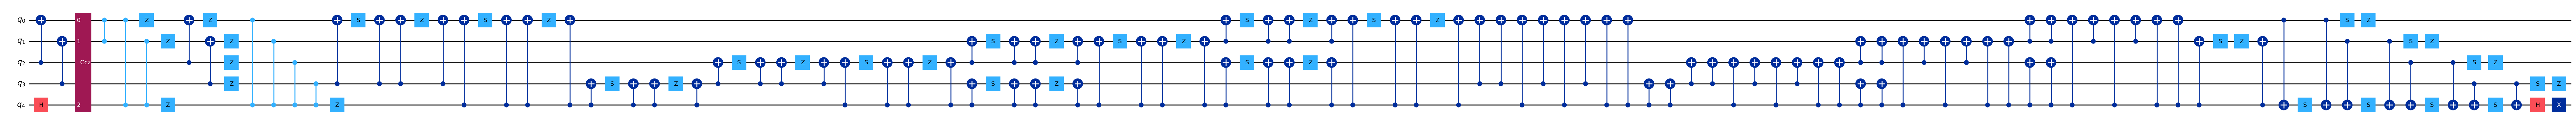

In [169]:
import qiskit

circ = qiskit.QuantumCircuit.from_qasm_file("outputs/mod_5_4.final.qasm")
circ.draw(output="mpl", scale=1.0, fold=0)

This is because we do not attempt to optimize this at any point in the compilation, because it is not part of our cost model. We can use various well-known methods to optimize this, e.g here we use Qiskit's Clifford synthesis methods:

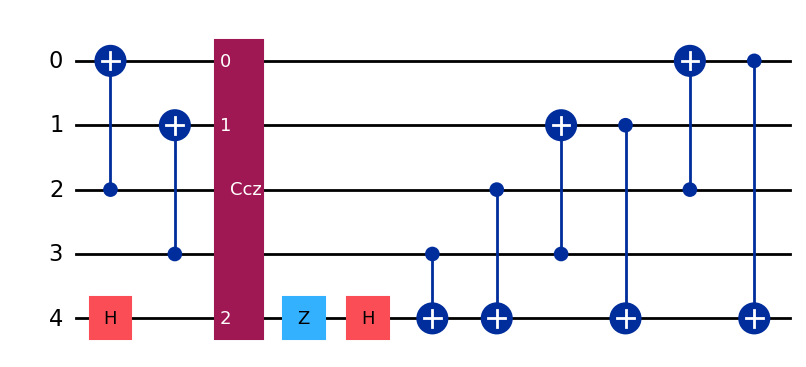

In [201]:
import qiskit.quantum_info
import qiskit.synthesis
import qiskit.qasm2


clifford_part = qiskit.QuantumCircuit.from_instructions(circ[4:], qubits=circ.qubits)
clifford_part = qiskit.quantum_info.Clifford(clifford_part)
clifford_part = qiskit.synthesis.synth_clifford_ag(clifford_part)

optimized = qiskit.QuantumCircuit.from_instructions(circ[:4], qubits=circ.qubits).compose(clifford_part)
qiskit.qasm2.dump(optimized, 'outputs/mod_5_4.final.qasm')
optimized.draw(output="mpl", scale=1.0, fold=0)

Up to some trivial commutation of gates, this is exactly (3) from Figure 3 in the paper! And we can see it is indeed equal to the original circuit:

In [202]:
%%bash
../target/release/circuit-to-tensor verify mod_5_4.qasm outputs/mod_5_4.final.qasm

Equal (took 0.015s)
